# Добрый день!

# Финальный спринт: Домен телекоммуникации

# Представляю проект  "Прогнозирование оттока клиентов".

# Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

# Описание услуг

Оператор предоставляет два основных типа услуг:

* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.

* Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:

* Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);

* Выделенная линия технической поддержки (`TechSupport`);

* Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);

* Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

# Задача

Построить и обучить модель классификации для прогноза оттока клиентов на основе 4 файлов с данными.

**Критерии построения моделей:**

- В данном проекте мы предсказываем ушел ли клиент вообще

- Бизнес-метрика здесь — это убытки по двум направлениям: 1) пользователю
предложили промокоды, но он не собирался уходить (false positive), 2)
пользователю ничего не предложили и он ушёл (false negative).

- AUC-ROC  — метрика, которая учитывает возможность балансировать между
false posititve и false negative.
В качестве дополнительной метрики будем использовать accuracy.

- Целевой ориентир по метрике **AUC-ROC >= 0.85**

- фиксируем параметр **RANDOM_STATE = 200524**

- размер тестовой выборки: **test_size = 0.25**

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Хорошо, когда есть подробное описание проекта и сформулирована основная задача — так постороннему человеку будет проще ознакомиться!   

</div>

# Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

**contract_new.csv** — информация о договоре;

`customerID` — идентификатор абонента;

`BeginDate` — дата начала действия договора;

`EndDate` — дата окончания действия договора;

`Type` — тип оплаты: раз в год-два или ежемесячно;

`PaperlessBilling` — электронный расчётный лист;

`PaymentMethod` — тип платежа;

`MonthlyCharges` — расходы за месяц;

`TotalCharges` — общие расходы абонента.

**personal_new.csv** — персональные данные клиента;

`customerID` — идентификатор пользователя;

`gender` — пол;

`SeniorCitizen` — является ли абонент пенсионером;

`Partner` — есть ли у абонента супруг или супруга;

`Dependents` — есть ли у абонента дети.

**internet_new.csv** — информация об интернет-услугах;

`customerID` — идентификатор пользователя;

`InternetService` — тип подключения;

`OnlineSecurity` — блокировка опасных сайтов;

`OnlineBackup` — облачное хранилище файлов для резервного копирования данных;

`DeviceProtection` — антивирус;

`TechSupport` — выделенная линия технической поддержки;

`StreamingTV` — стриминговое телевидение;

`StreamingMovies` — каталог фильмов.

**phone_new.csv** — информация об услугах телефонии.

`customerID` — идентификатор пользователя;

`MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

<h1>Содержание<span class="tocSkip"></span></h1>

<div class="toc"><ul class="toc-item"><li></li></ul></div>

## Загрузка данных

### Загрузка библиотек

In [ ]:
!pip install scikit-learn -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install lightgbm -q

In [ ]:
!pip install scikit-learn --upgrade -q

In [ ]:
# импорт библиотек

import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)


from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder)

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
# импорт функции для расчёта fpr, tpr, threshold
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay


from warnings import simplefilter # убираем ошибки
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# загрузка Phi_K

!pip install phik -q
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [ ]:
# загрузка t-test
from scipy import stats as st

In [ ]:
# загрузка SHAP

!pip install shap -q

 ### Загрузка файлов данных

In [ ]:
# чтение и загрузка файлов
contract = pd.read_csv('/datasets/contract_new.csv', sep=',', decimal = '.')
display(contract.head())
contract.shape

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


(7043, 8)

Целевой признак - **EndDate** (бинарный признак)

In [ ]:
# чтение и загрузка файлов
personal = pd.read_csv('/datasets/personal_new.csv', sep=',', decimal = '.')
display(personal.head())
personal.shape

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


(7043, 5)

In [ ]:
# чтение и загрузка файлов
internet = pd.read_csv('/datasets/internet_new.csv', sep=',', decimal = '.')
display(internet.head())
internet.shape

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


(5517, 8)

In [ ]:
# чтение и загрузка файлов
phone = pd.read_csv('/datasets/phone_new.csv', sep=',', decimal = '.')
display(phone.head())
phone.shape

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


(6361, 2)

**Вывод:**

1) Данные загружены корректно, размерность всех таблиц проверена. Данные в таблицах соответвуют описанию.

2) **Информация о договорах актуальна на 1 февраля 2020 года.**

3) contract - содержит 7043 строк и 8 столбцов

personal - содержит 7043 строк и 5 столбцов

internet - содержит 5517 строк и 8 столбцов

phone - содержит 6361 строк и 2 столбца

## Предобработка данных

Будем последовательно работать с каждым датасетом

In [ ]:
# проверяем форматы данных

for dataframe in [contract, personal, internet, phone]:
    print(dataframe.info())
    print('________________________\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
________________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner      

Вцелом форматы признаков определены верно, кроме `TotalCharges` можно также перевести в формат float64, как и `MonthlyCharges`.  

In [ ]:
# отобразим пропуски по этому столбцу, так как изначально выпало в ошибку преобразование во float

display(contract.query("TotalCharges ==' '"))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [ ]:
# заменим пропуски на 0
contract['TotalCharges'] = contract['TotalCharges'].str.replace(' ','0')

In [ ]:
# проверим еще раз как все преобразовалось
display(contract.query("TotalCharges == '0'"))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0


In [ ]:
# переформатируем значения в этом столбце в нужный формат и проверим итог
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Преобразования завершены успешно

In [ ]:
# проверяем пропуски в таблицах

for dataframe in [contract, personal, internet, phone]:
    print(dataframe.isna().sum().sort_values(ascending=False))
    print('________________________\n')

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
________________________

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
________________________

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
________________________

customerID       0
MultipleLines    0
dtype: int64
________________________



Пропуски в отдельных датасетах отсутствуют.

In [ ]:
# проверяем на дубликаты

for dataframe in [contract, personal, internet, phone]:
    print(dataframe.duplicated().sum())
    print('________________________\n')

0
________________________

0
________________________

0
________________________

0
________________________



Дубликаты отсутствуют.

In [ ]:
# проверка не неявные дубликаты

for column in contract.columns:
    print("Значения в столбце '", column,"':", contract[column].unique(), '\n')

Значения в столбце ' customerID ': ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

Значения в столбце ' BeginDate ': ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01'

In [ ]:
# проверка не неявные дубликаты

for column in personal.columns:
    print("Значения в столбце '", column,"':", personal[column].unique(), '\n')

Значения в столбце ' customerID ': ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

Значения в столбце ' gender ': ['Female' 'Male'] 

Значения в столбце ' SeniorCitizen ': [0 1] 

Значения в столбце ' Partner ': ['Yes' 'No'] 

Значения в столбце ' Dependents ': ['No' 'Yes'] 



In [ ]:
personal = personal.rename(columns={'gender': 'Gender'})

In [ ]:
# проверка не неявные дубликаты

for column in internet.columns:
    print("Значения в столбце '", column,"':", internet[column].unique(), '\n')

Значения в столбце ' customerID ': ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

Значения в столбце ' InternetService ': ['DSL' 'Fiber optic'] 

Значения в столбце ' OnlineSecurity ': ['No' 'Yes'] 

Значения в столбце ' OnlineBackup ': ['Yes' 'No'] 

Значения в столбце ' DeviceProtection ': ['No' 'Yes'] 

Значения в столбце ' TechSupport ': ['No' 'Yes'] 

Значения в столбце ' StreamingTV ': ['No' 'Yes'] 

Значения в столбце ' StreamingMovies ': ['No' 'Yes'] 



In [ ]:
# проверка не неявные дубликаты

for column in phone.columns:
    print("Значения в столбце '", column,"':", phone[column].unique(), '\n')

Значения в столбце ' customerID ': ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK'] 

Значения в столбце ' MultipleLines ': ['No' 'Yes'] 



Не явные дубликаты отсутствуют.

**Вывод:**

1) Пропуски в данных отсутствуют

2) Явные/Не явные дубликаты в данных не обнаружены

3)  Форматы данных в  столбце `TotalCharges` исправлен на float64

## Объединение данных

Для того, чтобы в дальнейшем использовать датасеты корректно, то объединим их в один.

### Объединение всех таблиц

In [ ]:
# объединяем таблицы contract и personal

teledom = contract.merge(personal, how = 'left', on='customerID')
display(teledom.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No


In [ ]:
# добавляем информацию к новой таблице из internet

teledom = teledom.merge(internet, how = 'left', on='customerID')
display(teledom.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No


In [ ]:
# добавляем информацию к новой таблице из phone

teledom = teledom.merge(phone, how = 'left', on='customerID')
display(teledom.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
#teledom.columns=teledom.columns.str.lower()

### Проверка и предобработка данных

In [ ]:
# посмотрим на формат данных

teledom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   Gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Итоговый датасет **teledom** содержит 7043 строк и 20 столбцов

In [ ]:
# посмотрим на строки, где есть NaN

display(teledom.head(12))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [ ]:
# выведем информацию о количестве пропусков

teledom.isna().sum().sort_values(ascending=False)

StreamingMovies     1526
StreamingTV         1526
TechSupport         1526
DeviceProtection    1526
OnlineBackup        1526
OnlineSecurity      1526
InternetService     1526
MultipleLines        682
BeginDate              0
Dependents             0
customerID             0
SeniorCitizen          0
Gender                 0
TotalCharges           0
MonthlyCharges         0
PaymentMethod          0
PaperlessBilling       0
Type                   0
EndDate                0
Partner                0
dtype: int64

Итоговый датасет содержит максимально 1526 пропусков (из датасета internet) и 682 пропуска (из датасета phone)

Эти пропуски заполним вставкой 'No'

In [ ]:
# список столбцов, в которых есть пропуски

columns = [['StreamingMovies',
            'StreamingTV',
            'TechSupport',
            'DeviceProtection',
            'OnlineBackup',
            'OnlineSecurity',
            'InternetService',
            'MultipleLines']]

In [ ]:
# производим замену NaN на No

for column in teledom.columns:
    teledom[column].fillna('No', inplace=True)

In [ ]:
# проверяем как прошли преобразования

teledom.isna().sum().sort_values(ascending=False)

customerID          0
BeginDate           0
StreamingMovies     0
StreamingTV         0
TechSupport         0
DeviceProtection    0
OnlineBackup        0
OnlineSecurity      0
InternetService     0
Dependents          0
Partner             0
SeniorCitizen       0
Gender              0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Type                0
EndDate             0
MultipleLines       0
dtype: int64

In [ ]:
display(teledom.head(12))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,No
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [ ]:
teledom.shape

(7043, 20)

In [ ]:
# проверка на дубликаты
dataframe.duplicated().sum()

0

Дубликаты отсутствуют

### Генерация новых признаков

In [ ]:
# отобразим еще раз данные по столбцам

display(teledom.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Столбцы `BeginDate` и `EndDate` содержат информацию о дате начала и окончания действия договора соответственно. Если `EndDate` содержит No, значит договор был активен 01.02.2020 (так как это дата выгрузки отчета / предосталвнеия данных).

**Для дальнейшего построения модели, необходимо привести наш целевой признак `EndDate` к бинарной метрике, где No = 0 и это будет означать, что договор по клиенту активен, а при наличии даты окончания = 1, то есть клиент ушел.**

In [ ]:
# введем новый признак - active_contract

teledom['ActiveContract'] = 1
teledom.loc[teledom['EndDate'] == 'No', 'ActiveContract'] = 0

In [ ]:
display(teledom.head(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ActiveContract
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,No,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No,1


Также мы можем ввести еще один признак - **продолжительность контракта (duration)**, то есть это разница между датой начала действия договора и датой окончания действия договора.

Этот признак в дальнейшем поможет нам посмотреть корреляцию между продолжительностью действия договора и лояльностью клиента, чтобы продолжать сотрудничество с компанией.

In [ ]:
# отформатируем даты, чтобы можно было производить расчет между ними

teledom['BeginDate'] = pd.to_datetime(teledom['BeginDate'], format='%Y-%m-%d')

In [ ]:
# отформатируем даты, чтобы можно было производить расчет между ними

teledom.loc[teledom['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
teledom['EndDate'] = pd.to_datetime(teledom['EndDate'], format='%Y-%m-%d')

In [ ]:
# введем новый признак - duration

teledom['Duration'] = (teledom['EndDate'] - teledom['BeginDate']).dt.components.days

In [ ]:
display(teledom.head(1))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ActiveContract,Duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31


Вцелом столбцы с датами нам уже не понадобятся для построения модели, поэтому можем их удалить.

In [ ]:
teledom = teledom.drop(['BeginDate', 'EndDate'], axis=1)
display(teledom.head(1))
teledom.shape

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ActiveContract,Duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31


(7043, 20)

В столбце `SeniorCitizen` содержатся числовые значения и формат данных int64.  Эти данные являются категориальными признаками и поэтому для унификации с другими категориальными значениями требуется его значения 0 и 1 привести к No и Yes соответственно, а тип данных `SeniorCitizen` привести к типу object

In [ ]:
# заменим значения 0 - No, 1 - Yes

teledom.loc[teledom['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
teledom.loc[teledom['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'

In [ ]:
display(teledom.head(1))
teledom.info()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ActiveContract,Duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   object 
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null   object 


**Вывод:**

1) Все 4 датасета были объединены в одну таблицу

2) Данные были повторно проверены на соотвествие форматам. Пропуски заполнены соотвествующим занчением по смыслу - 'No'

3) Были добавлены новые признаки: active_contract и duration

4) Также произведено преобразование в столбце SeniorCitizen: переведено в категориальный признак и формат object

##  Исследовательский анализ данных объединенного датафрейма

### Статистический анализ признаков

In [ ]:
# для статистического анализа по всем признакам воспользуемся функцией describe
# она доступна только для числовых столбцов
teledom.describe()

,MonthlyCharges,TotalCharges,ActiveContract,Duration
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.156325,898.555729
std,30.090047,2112.742814,0.363189,683.130510
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000
50%,70.350000,1343.350000,0.000000,761.000000
75%,89.850000,3236.690000,0.000000,1461.000000
max,118.750000,9221.380000,1.000000,2314.000000


В датасете у нас 3 количественных признаков (MonthlyCharges, TotalCharges, duration). По максимальным значениям можно предположить, что есть выбросы, далее мы это проверим с помощью диаграммы размаха.

В столбцах TotalCharges и duration очень высокое стандартное отклонение, что может говорить нам о неоднородности данных.

### Графики для признаков - надо добавить графики

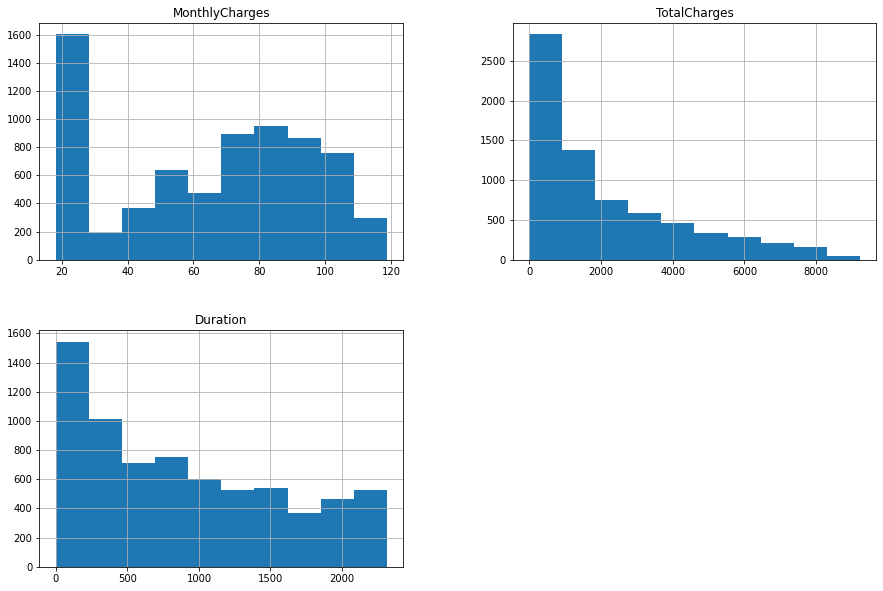

In [ ]:
# построим график для количественных признаков датасета

col_teledom = teledom[['MonthlyCharges',
                     'TotalCharges',
                     'Duration']]
col_teledom.hist(figsize=(15,10), bins=10)
plt.xlabel('значение признака')
plt.ylabel('частота');

**Комментарии к графикам:**

1) MonthlyCharges - это признак обозначает расходы за месяц. В основном клиенты тратят от 20 до 30 условных единиц платежной системы, возможно это какой-то пробный период. Остальные клиенты отражены на гистограмме и представляют собой нормальное рпаспределение по расходам в месяц - в среднем от 60 до 100 у.е.: либо это связано с определенной тарификацией, либо абоненты покупают не только телефонию, но и другие услуги и абонентская плата суммируется.

2) TotalCharges - это признак обозначает общие расходы абонента. В основном абоненты тратят до 1000 у.е. платежной системы. На гистограмме видим "хвост справа", что говорит нам о том, что скорее всего доля "старых" клиентов ниже, чем "новых", то есть старенькие уже имеют достаточно высокие расходы накопительным итогом возможно.

3) duration - это признак обозначает продолжительность контракта в днях. В основном клиенты пользуются услугами меньше года (до 250 дней). Остальная часть клиентов достаточно стабильна и лояльна к компании и взаимодействует с ней достаточно долго.

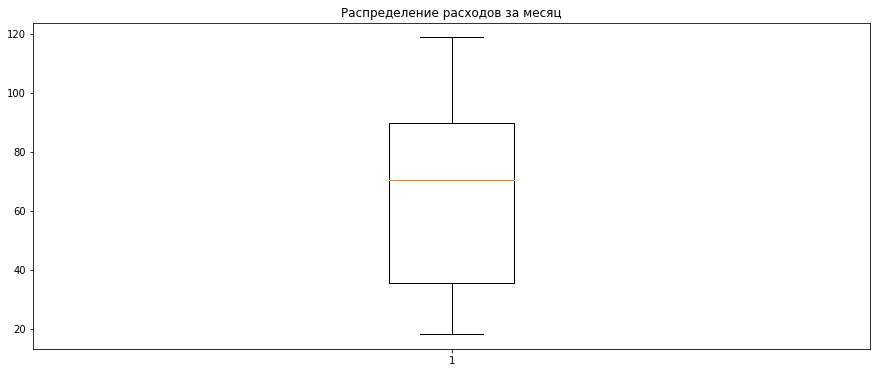

In [ ]:
# построили график "ящик с усами"

plt.figure(figsize=(15,6))

plt.title('Распределение расходов за месяц')
plt.boxplot(teledom['MonthlyCharges'])
plt.show();

Показатель достаточно стабильный, выбросы отсутствуют, так как фиксированная плата в мес.

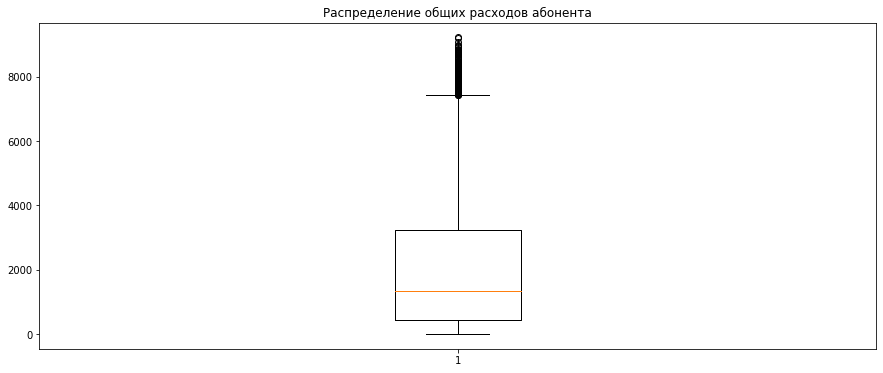

In [ ]:
# построили график "ящик с усами"

plt.figure(figsize=(15,6))

plt.title('Распределение общих расходов абонента')
plt.boxplot(teledom['TotalCharges'])
plt.show();

Есть небольшое количество выбросов, выше максимальных значений. Так как "природа" этих расходов подробно не обозначена, что туда включено, то можем посмотреть какое количество строк по расходам выше 8 тыс.

In [ ]:
display(teledom.query("TotalCharges > 8000").count())

customerID          99
Type                99
PaperlessBilling    99
PaymentMethod       99
MonthlyCharges      99
TotalCharges        99
Gender              99
SeniorCitizen       99
Partner             99
Dependents          99
InternetService     99
OnlineSecurity      99
OnlineBackup        99
DeviceProtection    99
TechSupport         99
StreamingTV         99
StreamingMovies     99
MultipleLines       99
ActiveContract      99
Duration            99
dtype: int64

Так как этих выбросов не очень много и эти значения не влияют на наш целевой признак, то удалять их не будем.

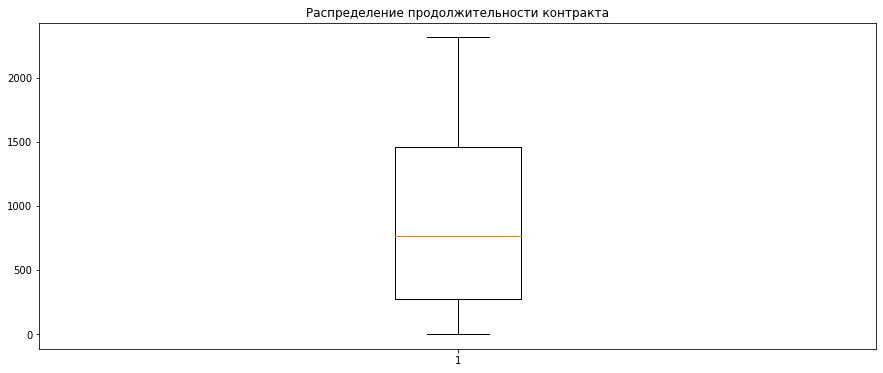

In [ ]:
# построили график "ящик с усами"

plt.figure(figsize=(15,6))

plt.title('Распределение продолжительности контракта')
plt.boxplot(teledom['Duration'])
plt.show();

Показатель достаточно стабильный, выбросы отсутствуют.

**Посмотрим также на распределение целевого признака графически**

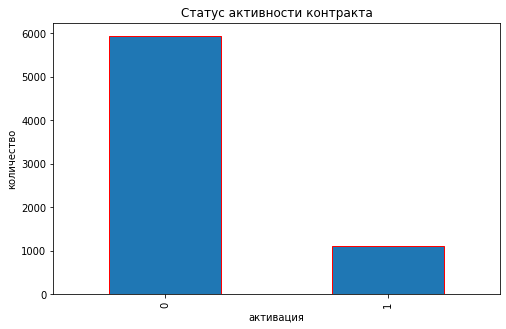

In [ ]:
# посмотрим как распределен целевой признак

teledom['ActiveContract'].value_counts().plot(kind='bar', figsize=(8,5), ec='red')
plt.title('Статус активности контракта')
plt.xlabel('активация')
plt.ylabel('количество')
plt.show();

На графике видим явный дисбаланс классов: количество активных контрактов значительно выше закрытых. Учтем этот момент при построении моделей.

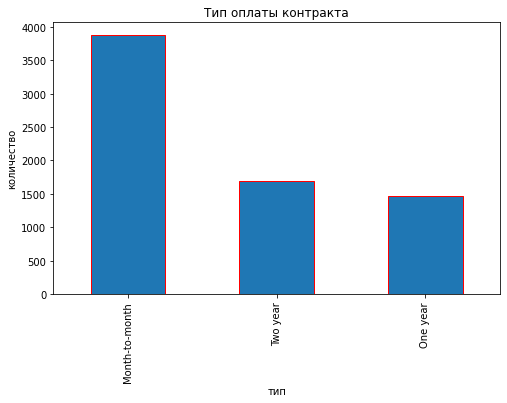

In [ ]:
teledom['Type'].value_counts().plot(kind='bar', figsize=(8,5), ec='red', stacked=True)
plt.title('Тип оплаты контракта')
plt.xlabel('тип')
plt.ylabel('количество')
plt.show();

Наибольшей популярностью пользуется типа оплаты - ежемесячный, остальные типы (годовой и двухгодичный) примерно в одинаковом соотношении.

**Построим ряд графиков по имеющимся признакам для составления портрета клиента**

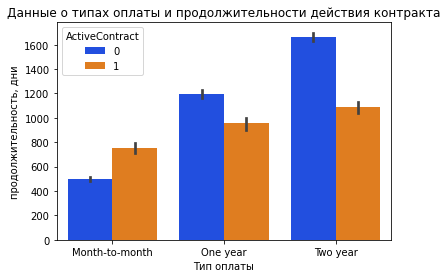

In [ ]:
# посмотрим на общее распределение продолжительности контракта и  типа оплаты

sns.barplot(
    x='Type',
    y='Duration',
    data=teledom,
    hue='ActiveContract',
    palette='bright')
plt.title('Данные о типах оплаты и продолжительности действия контракта')
plt.xlabel('Тип оплаты')
plt.ylabel('продолжительность, дни')
plt.show();

Больше всего уходят клиенты при типе оплаты Month-to-month, возможно это связано с пробной версией. Более стабильные клиенты с типом оплаты Two year/

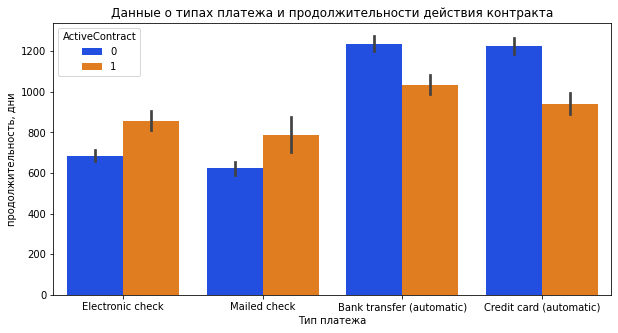

In [ ]:
# посмотрим на общее распределение продолжительности контракта и  типа платежа

plt.figure(figsize=(10,5))
sns.barplot(
    x='PaymentMethod',
    y='Duration',
    data=teledom,
    hue='ActiveContract',
    palette='bright')
plt.title('Данные о типах платежа и продолжительности действия контракта')
plt.xlabel('Тип платежа')
plt.ylabel('продолжительность, дни')
plt.show();

Наиболее лояльные клиенты к долгосрочному сотрудничеству оплачивают типами Bank transfer и Credit card

Клиенты, которые чаще всего уходят, платят Electronic check и Mailed check - этот момент можно учесть при рекомендациях заказчику.

In [ ]:
# сформируем сводную таблицу для оставшихся признаков для составления портрета клиента

portret = pd.pivot_table(teledom,
                            index = 'ActiveContract',
                            columns = ['Gender'
                                       #'SeniorCitizen',
                                       #'Partner',
                                       #'Dependents'
                                      ],
                            values = 'customerID',
                            aggfunc = ['count'])

portret = portret.rename(columns={'count':''})
display(portret)

Gender         Female  Male
ActiveContract             
0                2960  2982
1                 528   573

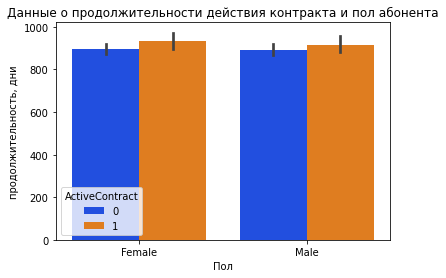

In [ ]:
# посмотрим на общее распределение продолжительности контракта и пол абонента

#plt.figure(figsize=(10,5))
sns.barplot(
    x='Gender',
    y='Duration',
    data=teledom,
    hue='ActiveContract',
    palette='bright')
plt.title('Данные о продолжительности действия контракта и пол абонента')
plt.xlabel('Пол')
plt.ylabel('продолжительность, дни')
plt.show();

Мы видим, что в равной степени услугами пользуются и мужчины, и женщины.

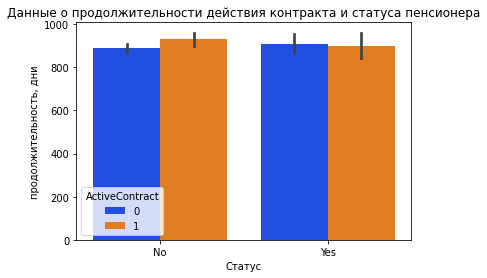

In [ ]:
# посмотрим на общее распределение продолжительности контракта и является ли абонент пенсионером

sns.barplot(
    x='SeniorCitizen',
    y='Duration',
    data=teledom,
    hue='ActiveContract',
    palette='bright')
plt.title('Данные о продолжительности действия контракта и статуса пенсионера')
plt.xlabel('Статус')
plt.ylabel('продолжительность, дни')
plt.show();

Мы видим, что в равной степени услугами пользуются и пенсионеры, и работающие.

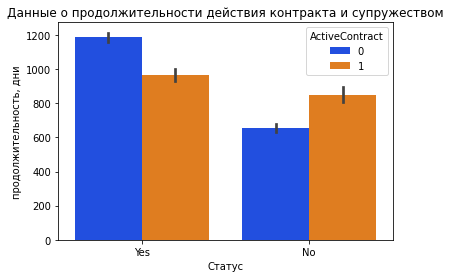

In [ ]:
# посмотрим на общее распределение продолжительности контракта и супружеством

sns.barplot(
    x='Partner',
    y='Duration',
    data=teledom,
    hue='ActiveContract',
    palette='bright')
plt.title('Данные о продолжительности действия контракта и супружеством')
plt.xlabel('Статус')
plt.ylabel('продолжительность, дни')
plt.show();

Наибольшее количество абонентов находятся в семейных отношениях и имеют бОльшую продолжительность контрактов с компанией.

При этом в равной степени отказываются от услуг компании, как супружеские пары, так и свободные.

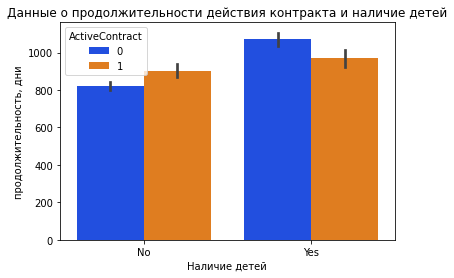

In [ ]:
# посмотрим на общее распределение продолжительности контракта и есть ли у абонента дети

sns.barplot(
    x='Dependents',
    y='Duration',
    data=teledom,
    hue='ActiveContract',
    palette='bright')
plt.title('Данные о продолжительности действия контракта и наличие детей')
plt.xlabel('Наличие детей')
plt.ylabel('продолжительность, дни')
plt.show();

Чуть больше абонентов лояльны к компании и имеют контракт люди с детьми, нежели без них.

При этом в равной степени отказываются от услуг компании, как те кто с детьми, так и кто без них.

### Корреляционный анализ

Для проведения корреляционного анализа используем библиотеку phik для подсчёта корреляции между признаками разных типов данных, учитывая еще тот фактор, что наш датасет содержит большое количество категориальных признаков.

In [ ]:
# создаём список с наименованиями непрерывных признаков

interval_cols = ['MonthlyCharges',
                     'TotalCharges',
                         'Duration']

In [ ]:
# удаляем столбец с идентификаторами пользователя, так как они информацию не несут

teledom = teledom.set_index('customerID')

In [ ]:
# вычисление коэффициентов корреляции phi для датафрейма df

phik_overview = teledom.phik_matrix(interval_cols=interval_cols)

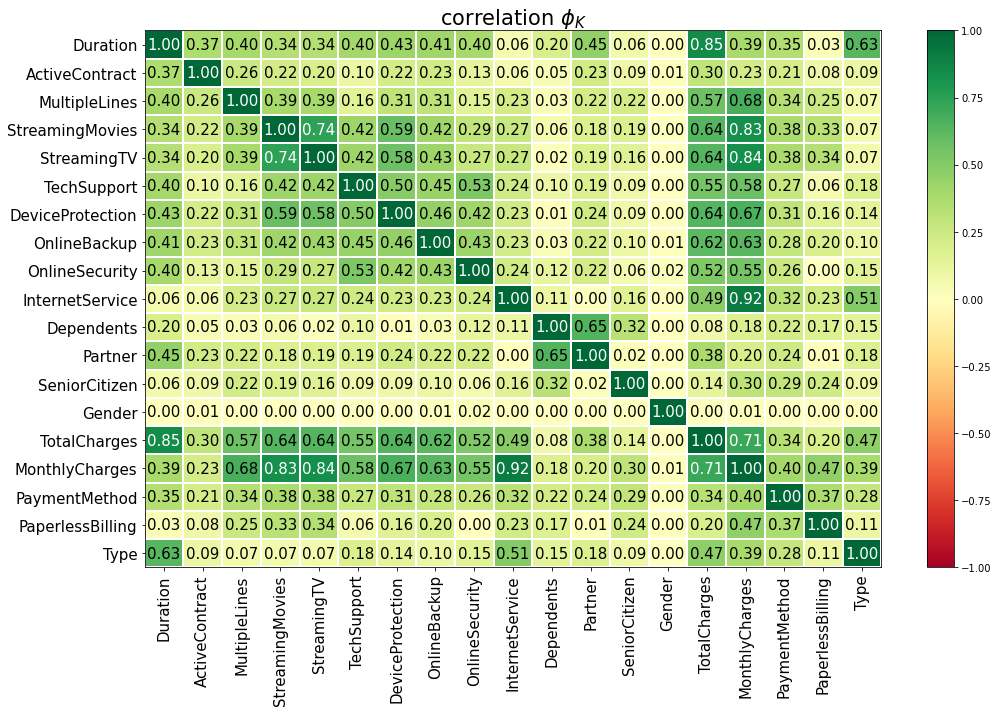

In [ ]:
# визуализация тепловой карты коэффициентов корреляции

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 10))

**Корреляция:**

Высокая корреляция 0,7 - 0,9 между признаками: MonthlyCharges и InternetService (0.92), TotalCharges и duration (0.85), MonthlyCharges и StreamingTV (0.84), MonthlyCharges и StreamingMovies (0.83).

Средняя корреляция 0,4 - 0,7 между признаками: StreamingMovies и StreamingTV (0.74), MonthlyCharges и MultipleLines (0.68) , MonthlyCharges и TotalCharges (0.71), TotalCharges и StreamingTV / StreamingMovies (0.64).

**Вывод:**

1) Статистический анализ показал нам: В датасете у нас 3 количественных признаков (MonthlyCharges, TotalCharges, duration). В столбцах TotalCharges и duration очень высокое стандартное отклонение, что может говорить нам о неоднородности данных.

2) Графики по признакам позволили составить портрет лояльного клиента, который стабилен и пользуется услугами компании:

* MonthlyCharges. В основном клиенты тратят от 20 до 30 условных единиц платежной системы, возможно это какой-то пробный период. Остальные клиенты по расходам в месяц - в среднем от 60 до 100 у.е.

* TotalCharges. В основном абоненты тратят до 1000 у.е. платежной системы.

* duration. В основном клиенты пользуются услугами меньше года (до 250 дней).

3) **Портрет клиента.** Целевой признак активности контракта - На графике виден явный дисбаланс классов: количество активных контрактов значительно выше закрытых.

* Наибольшей популярностью пользуется типа оплаты - ежемесячный, остальные типы (годовой и двухгодичный) примерно в одинаковом соотношении.

* Более стабильные клиенты с типом оплаты Two year.

* Наиболее лояльные клиенты к долгосрочному сотрудничеству оплачивают типами Bank transfer и Credit card.

* В равной степени услугами пользуются и мужчины, и женщины / среди них также одинаково ведут себя и пенсионеры, и работающие.

* Наибольшее количество абонентов находятся в семейных отношениях и имеют бОльшую продолжительность контрактов с компанией.

* Чуть больше абонентов лояльны к компании и имеют контракт люди с детьми, нежели без них.

4) Проведен корреляционный анализ признаков, выводы оформлены выше.

## Подготовка данных

Сначала обозначим, какие данные требуют масштабирования, а какие — кодирования. Признаки будем кодировать разными методами

### Определение параметров и выборок

In [ ]:
# зададим константы

RANDOM_STATE = 200524
TEST_SIZE = 0.25

In [ ]:
# определим целевой показатель

X = teledom.drop('ActiveContract', axis=1)
y = teledom['ActiveContract']

In [ ]:
# разделение датасета на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE,
                                                    test_size = TEST_SIZE)

In [ ]:
for dataframe in [X_train, X_test, y_train, y_test]:
    print(dataframe.shape)
    print('________________________\n')

(5282, 18)
________________________

(1761, 18)
________________________

(5282,)
________________________

(1761,)
________________________



Разделение на подвыборки прошло корректно.

### Создание пайплайна

In [ ]:
# сформируем списки для кодирования признаков

# категориальные
ohe_columns = ['Type',
                'PaperlessBilling',
               'PaymentMethod',
               'Gender',
               'SeniorCitizen',
              'Partner',
              'Dependents',
               'InternetService',
              'OnlineSecurity',
              'OnlineBackup',
               'DeviceProtection',
               'TechSupport',
               'StreamingTV',
               'StreamingMovies',
               'MultipleLines']

# ранговые
#ord_columns = ['Type',
#               'PaymentMethod',
               #'Gender',
               #'SeniorCitizen',
#              'InternetService']

# количественные
num_columns = ['MonthlyCharges',
               'TotalCharges',
               'Duration']

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns
# SimpleImputer + OHE

ohe_pipe = Pipeline(
    [#('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output = False ))]) #, sparse=False))])

In [ ]:
# создаём пайплайн для подготовки признаков из списка ord_columns
# SimpleImputer + ORD + SimpleImputer

#ord_pipe = Pipeline(
#    [#('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#        ('ord', OrdinalEncoder(categories=[
#                    ['Month-to-month', 'One year', 'Two year'],
#                    ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'],
                   #['Female', 'Male'],
                    #[0, 1],
#                    ['DSL', 'Fiber optic']
#        ],
#                handle_unknown='use_encoded_value', unknown_value=np.nan))])#,
        #('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

In [ ]:
# подготовка общего пайплайна для подготовки данных
# preprocessor__num = preprocessor_ + _num:
# preprocessor__num — пайплайн, в котором находится шаг масштабирования
# num — шаг масштабирования с методом и списком столбцов
# заодно укажем 'passthrough' — вариант без масштабирования

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
#        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
# создаём итоговый пайплайн: подготовка данных и модель

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

In [ ]:
display(X_train.head(1))

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Duration
customerID,,,,,,,,,,,,,,,,,,
7698-YFGEZ,Month-to-month,No,Mailed check,20.0,22.0,Male,No,No,No,No,No,No,No,No,No,No,No,31


## Обучение моделей

В каждом словаре указываем название модели, её гиперпараметры, метод масштабирования — всё, что хотим перебрать в качестве гиперпараметров модели.

Что есть в словаре:

model – название модели;

model__n_neighbors — задаём гиперпараметр nneighbors для модели model_ из pipe_final;

preprocessor__num – обращаемся к шагу preprocessor в пайплайне pipe_final,

а затем к шагу num в пайплайне data_preprocessor.

### Подбор параметров модели

In [ ]:
param_grid = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='saga',
            penalty='l1'
        )],
        'models__C': range(1,5) ,
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

       # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,7),
        'models__max_features': range(1,7),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(loss_function="Logloss",  iterations=200)],
        'models__learning_rate':[0.1, 0.5],
        'models__max_depth': range(1,7),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    # словарь для модели LightGBM()
    {
        'models': [LGBMClassifier(objective='binary', random_state=RANDOM_STATE)],
        'models__learning_rate':[0.1, 0.5],
        'models__max_depth': range(1,7),
       #'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

### Обучение четырех моделей

Для автоматического подбора гиперпараметров будем использовать инструмент RandomizedSearchCV.

models — инициализированная модель

param_grid — словарь с гиперпараметрами модели

cv — тип кросс-валидации

scoring — метрика, которую используем для выбора лучшего решения

n_jobs=-1 — подключаем к расчёту ядра процессора

In [ ]:
# чтобы найти лучшее решение, перебирать будем и гиперпараметры, и методы подготовки данных.
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=10)

При подборе лучшей модели мы используем метрику ROC-AUC_SCORE, так как целевой признак "Активность контракта" в нашем проекте бинарный.

Метрика ROC-AUC устойчива к несбалансированным классам, что является важным свойством в реальных задачах. Она не зависит от порога классификации и позволяет оценить качество модели независимо от выбранного порога

In [ ]:
# обучаем на тренировочных данных

randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START models=DecisionTreeClassifier(random_state=200524), models__max_depth=5, models__max_features=1
[CV 1/5; 1/10] END models=DecisionTreeClassifier(random_state=200524), models__max_depth=5, models__max_features=1;, score=0.661 total time=   0.1s
[CV 2/5; 1/10] START models=DecisionTreeClassifier(random_state=200524), models__max_depth=5, models__max_features=1
[CV 2/5; 1/10] END models=DecisionTreeClassifier(random_state=200524), models__max_depth=5, models__max_features=1;, score=0.659 total time=   0.1s
[CV 3/5; 1/10] START models=DecisionTreeClassifier(random_state=200524), models__max_depth=5, models__max_features=1
[CV 3/5; 1/10] END models=DecisionTreeClassifier(random_state=200524), models__max_depth=5, models__max_features=1;, score=0.707 total time=   0.1s
[CV 4/5; 1/10] START models=DecisionTreeClassifier(random_state=200524), models__max_depth=5, models__max_features=1
[CV 4/5; 1/10] END models=D

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'Gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'Devic...
                                         'models__max_features': range(1, 7)},
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x7fd31ce4ac70>],
                                         'models__learning_rate': [0.1, 0.5],
                                         'models__max_depth': range(1, 7)},
                                        {'models': [LGBMClassifier(objective='binary',
                                                                   random_state=200524)],
                                         'models__learning_rate': [0.1, 0.5],
                                         'models__max_depth': range(1, 7)}],
                   random_state=200524, scoring='roc_auc', verbose=10)

## Выбор и тестирование модели

In [ ]:
# получим все результаты и сделаем из них датафрейм

result = pd.DataFrame(randomized_search.cv_results_)

### Выбор лучшей модели

In [ ]:
# посмотрим результат работы всех моделей

display(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score'))

,rank_test_score,param_models,mean_test_score,params
5,1,"LGBMClassifier(objective='binary', random_stat...",0.883791,"{'models__max_depth': 4, 'models__learning_rat..."
4,2,<catboost.core.CatBoostClassifier object at 0x...,0.870206,"{'models__max_depth': 6, 'models__learning_rat..."
9,3,<catboost.core.CatBoostClassifier object at 0x...,0.854698,"{'models__max_depth': 3, 'models__learning_rat..."
2,4,DecisionTreeClassifier(random_state=200524),0.732132,"{'models__max_features': 6, 'models__max_depth..."
7,5,DecisionTreeClassifier(random_state=200524),0.730330,"{'models__max_features': 6, 'models__max_depth..."
6,6,DecisionTreeClassifier(random_state=200524),0.709220,"{'models__max_features': 4, 'models__max_depth..."
0,7,DecisionTreeClassifier(random_state=200524),0.677471,"{'models__max_features': 1, 'models__max_depth..."
1,8,DecisionTreeClassifier(random_state=200524),0.671904,"{'models__max_features': 4, 'models__max_depth..."
3,9,DecisionTreeClassifier(random_state=200524),0.666718,"{'models__max_features': 3, 'models__max_depth..."
8,10,DecisionTreeClassifier(random_state=200524),0.580439,"{'models__max_features': 5, 'models__max_depth..."


In [ ]:
# выведем лучшие параметры

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod', 'Gender',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                    

### Тестирование лучшей модели

In [ ]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))


Площадь ROC-кривой: 0.9032147222399481


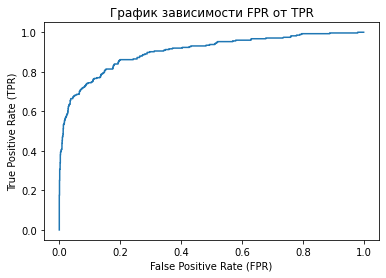

In [ ]:
# рассчитаем значения FPR и TRP
fpr, tpr, threshold = roc_curve(y_test, probabilities[:, 1])#, pos_label='Jazz')

# построим график зависимости FPR от TPR
plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

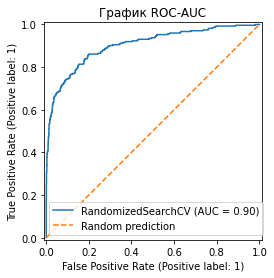

In [ ]:
# выведите на экран ROC-кривую методом from_estimator()

#RocCurveDisplay.from_predictions(y_test, probabilities[:, 1])
RocCurveDisplay.from_estimator(randomized_search, X_test, y_test)
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title("График ROC-AUC")
plt.legend()
plt.show()

In [ ]:
# рассчитали метрику accuracy на тестовой выборке

accuracy = accuracy_score(y_test, randomized_search.predict(X_test))
print('Метрика accuracy на тестовой выборке:', accuracy)

Метрика accuracy на тестовой выборке: 0.9142532651902329


## Анализ важности признаков

### Оценка важности признаков для лучшей модели и график важности

Так как лучшей моделью оказалась LGBMClassifier(learning_rate=0.5, max_depth=4,
                                objective='binary', random_state=200524, то проверку коэффициентов и оценку важности признаков будем проводить на ней

In [ ]:
# Анализ важности признаков

pd.DataFrame(
    randomized_search.best_estimator_[-1].feature_importances_,
    index=randomized_search.best_estimator_[:-1].get_feature_names_out(),
    columns=['Важность признака']
).sort_values(by='Важность признака', ascending=False)

,Важность признака
num__Duration,426
num__MonthlyCharges,234
num__TotalCharges,181
ohe__Gender_Male,31
ohe__Partner_Yes,31
ohe__MultipleLines_Yes,28
ohe__Type_One year,28
ohe__Dependents_Yes,25
ohe__SeniorCitizen_Yes,20
ohe__Type_Two year,20


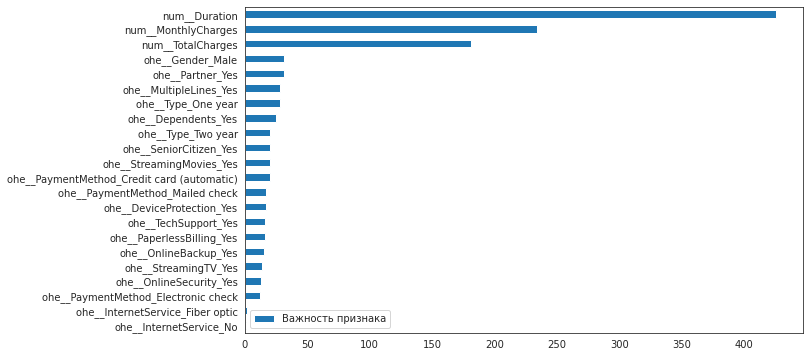

In [ ]:
# строим график важности признаков по величине коэффициентов
coefficients = randomized_search.best_estimator_[-1].feature_importances_
sns.set_style('white')
feature_importance = pd.DataFrame(
    randomized_search.best_estimator_[-1].feature_importances_,
    index=randomized_search.best_estimator_[:-1].get_feature_names_out(),
    columns=['Важность признака']
).sort_values(by='Важность признака', ascending=False)
feature_importance = feature_importance.sort_values('Важность признака', ascending=True)
feature_importance.plot(y='Важность признака', kind='barh', figsize=(10, 6));

Самые значимые признаки: "Duration" и "MonthlyCharges", "TotalCharges"

Менее значиные признаки: "Gender_Male", "Partner", "MultipleLines" и "Type", "Dependents"

Изменение этих признаков приведет к значительному изменению предсказаний.

Замыкает этот рейтинг признак "InternetService". Изменение этого признака в наименьшей степени повлияет на предсказание.

## Общий вывод и рекомендации заказчику

Перед нами стояла задача разработать решение, которое позволит **персонализировать предложения лояльным клиентам (это предложение промокодов и специальных условий), чтобы сохранить сотрудничество с ними и продление контрактов связи**, которое состояло из нескольких этапов:

1. Загрузка данных - предосталено было 4 файла: информация о договоре, персональные данные клиента, информация об интернет-услугах, информация об услугах телефонии.

2. Предобработка данных и объединение 4 датасетов в один.

3. Исследовательский анализ объединенных данных и выявление закономерностей.

4. Подготовка данных к обучению моделей: кодирование, масштабирование, составление пайплайна

5. Выбор моделей и подбор их гиперпараметров. Выбор наилучшей модели, которая бы достигала целевых ориентиров.

6. Тестирование лучшей модели на тестовой выборке.

7. Выводы и рекомендации заказчикам.

**Критерии построения моделей:**

В данном проекте мы предсказываем ушел ли клиент вообще

Бизнес-метрика здесь — это убытки по двум направлениям: 1) пользователю предложили промокоды, но он не собирался уходить (false positive), 2) пользователю ничего не предложили и он ушёл (false negative).

AUC-ROC — метрика, которая учитывает возможность балансировать между false posititve и false negative. В качестве дополнительной метрики будем использовать accuracy.

Целевой ориентир по метрике **AUC-ROC >= 0.85**

фиксируем параметр **RANDOM_STATE = 200524**

размер тестовой выборки: **test_size = 0.25**

**В ходе предобработки данных были проведены следующие итерации:**

1) Объединение 4 файлов с аднными в один

2) Проверка на пропуски. Пропуски в данных обработаны

3) Проверка дубликатов.Явные дубликаты / Не явные дубликаты в данных не обнаружены

4) Форматы данных в столбце TotalCharges исправлен на float64

5) Были добавлены новые признаки: ActiveContract и Duration

6) Также произведено преобразование в столбце SeniorCitizen: переведено в категориальный признак и формат object

**Для поиска лучшей модели было сделано:**

Были подготовлены данные для обучения моделей: целевой признак "Активность контракта" приведен к бинарному формату, удалены лишние столбцы

Были сформированы:

**1)** паплайны для кодирования и масштабирования категориальных и количественных признаков с помощью кодировщиков OneHotEncoder, и скейлеров MinMaxScaler и StandardScaler

**2)** пайплайны с моделями и с их гиперпараметрами

Была отражена таблица с результатами работы моделей и их лучшими параметрами. Данные были осортированы по убыванию лучшего значения метрики.

# Итоги для заказчика:

**1) Статистический анализ** показал нам: В датасете у нас 3 количественных признаков (MonthlyCharges, TotalCharges, duration). В столбцах TotalCharges и duration очень высокое стандартное отклонение, что может говорить нам о неоднородности данных.

**2) Графики по признакам** позволили составить портрет лояльного клиента, который стабилен и пользуется услугами компании:

MonthlyCharges. В основном клиенты тратят от 20 до 30 условных единиц платежной системы, возможно это какой-то пробный период. Остальные клиенты по расходам в месяц - в среднем от 60 до 100 у.е.

TotalCharges. В основном абоненты тратят до 1000 у.е. платежной системы.

Duration. В основном клиенты пользуются услугами меньше года (до 250 дней).

**3) Портрет клиента.** Целевой признак активности контракта - На графике виден явный дисбаланс классов: количество активных контрактов значительно выше закрытых.

Наибольшей популярностью пользуется типа оплаты - ежемесячный, остальные типы (годовой и двухгодичный) примерно в одинаковом соотношении.

Более стабильные клиенты с типом оплаты Two year.

Наиболее лояльные клиенты к долгосрочному сотрудничеству оплачивают типами Bank transfer и Credit card.

В равной степени услугами пользуются и мужчины, и женщины / среди них также одинаково ведут себя и пенсионеры, и работающие.

Наибольшее количество абонентов находятся в семейных отношениях и имеют бОльшую продолжительность контрактов с компанией.

Чуть больше абонентов лояльны к компании и имеют контракт люди с детьми, нежели без них.

**4) Корреляция:**

Высокая корреляция 0,7 - 0,9 между признаками: MonthlyCharges и InternetService (0.92), TotalCharges и duration (0.85), MonthlyCharges и StreamingTV (0.84), MonthlyCharges и StreamingMovies (0.83).

Средняя корреляция 0,4 - 0,7 между признаками: StreamingMovies и StreamingTV (0.74), MonthlyCharges и MultipleLines (0.68) , MonthlyCharges и TotalCharges (0.71), TotalCharges и StreamingTV / StreamingMovies (0.64).

**5) Результаты работы модели:**

По итогам отработки пайплайна лучшей моделью оказалсь **LGBMClassifier(learning_rate=0.5, max_depth=4,
                                objective='binary', random_state=200524))])
Метрика лучшей модели на кросс-валидации: 0.8837914334616294**

На тестовой выборке Метрика **Площадь ROC-кривой на тестовой выборке: Площадь ROC-кривой: 0.9032147222399481**

**Метрика accuracy на тестовой выборке: 0.91425326519023**

Мы использовали один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернул нам лучшую модель